In [1]:
using Gadfly
using Interact
using Gurobi

In [2]:
using JuMP

In [333]:
typealias VarExpr Union{JuMP.Variable, JuMP.AffExpr}

function trig_approximation!(m::Model, theta::VarExpr, c::VarExpr, s::VarExpr, rho::AbstractVector{Variable})
    M_big = 10
    num_bins = length(rho)
    theta0 = 0.0
    theta_step = 3pi / num_bins
    bins_below = Int(floor(num_bins / 2))
    for bin in 1:num_bins
        theta_center = theta0 + (bin - bins_below - 1) * theta_step
        theta_lb = theta_center - theta_step / 2
        theta_ub = theta_center + theta_step / 2
        v = [cos(theta_center), sin(theta_center)]
        @constraints(m, begin
            dot(v, [c, s]) <= 1 + 0.1 * (1 - rho[bin])
            dot(v, [c, s]) >= 1 - M_big * (1 - rho[bin])
        end)
        
        subspace = [-sin(theta_center), cos(theta_center)]
        dx = [c - cos(theta_center), s - sin(theta_center)]
        dtheta = theta - theta_center
        @constraints(m, begin
            dot(subspace, dx) <= dtheta + (M_big * (1 - rho[bin]))
            dot(subspace, dx) >= dtheta - (M_big * (1 - rho[bin]))
            theta <= theta_ub + M_big * (1 - rho[bin])
            theta >= theta_lb - M_big * (1 - rho[bin])
        end)
    end
end

function trig_approximation_chull(m::Model, theta::JuMP.Variable, rho::Vector{JuMP.Variable})
    @variable m c
    @variable m s
    num_bins = length(rho)
    theta0 = 0.0
    theta_step = 3pi / num_bins
    bins_below = Int(floor(num_bins / 2))
    cs = Variable[]
    ss = Variable[]
    thetas = Variable[]
    for bin in 1:num_bins
        @variable m ci
        push!(cs, ci)
        @variable m si
        push!(ss, si)
        @variable m thetai
        push!(thetas, thetai)
        
        
        theta_center = theta0 + (bin - bins_below - 1) * theta_step
        theta_lb = theta_center - theta_step / 2
        theta_ub = theta_center + theta_step / 2
        v = [cos(theta_center), sin(theta_center)]
        
        @constraint(m, dot(v, [ci, si]) <= 1 * rho[bin])
        @constraint(m, dot(v, [ci, si]) >= 1 * rho[bin])
        
        subspace = [-sin(theta_center), cos(theta_center)]
        dx = [ci - cos(theta_center), si - sin(theta_center)]
        dtheta = thetai - theta_center
        @constraint(m, dot(subspace, dx) <= dtheta * rho[bin])
        @constraint(m, dot(subspace, dx) >= dtheta * rho[bin])
        @constraint(m, theta_lb * rho[bin] <= thetai)
        @constraint(m, thetai <= theta_ub * rho[bin])
    end
    @constraint m c == sum(cs)
    @constraint m s == sum(ss)
    @constraint m theta == sum(thetas)
    c, s
end


trig_approximation_chull (generic function with 1 method)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x0",0.0,linspace(-3.0,3.0,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"y0",0.0,linspace(-3.0,3.0,51),".3f",true)

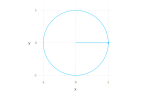

In [334]:
@manipulate for x0 in linspace(-3, 3, 51), y0 in linspace(-3, 3, 51)
    m = Model(solver=Gurobi.GurobiSolver(OutputFlag=0))
    @variable m theta
    @variable m rho[1:9] Bin
    @constraint m sum(rho) == 1
    @variable m c
    @variable m s
#     @constraint m theta >= 0
    trig_approximation!(m, theta, c, s, rho)

    @objective m Min (c - x0)^2 + (s - y0)^2
    status = solve(m)
    plot(
        layer(x=cos.(linspace(0, 2*pi)), y=sin.(linspace(0, 2*pi)), Geom.line(preserve_order=true)),
        layer(x=[getvalue(c)], y=[getvalue(s)], Geom.point),
        layer(x=cos(getvalue(theta)).*linspace(0, 1), y=sin(getvalue(theta)).*linspace(0,1), Geom.line(preserve_order=true)),
        Coord.cartesian(aspect_ratio=1, ymin=-1.1, ymax=1.1, xmin=-1.1, xmax=1.1)
    )

end

Optimize a model with 668 rows, 160 columns and 1914 nonzeros
Model has 60 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-01, 1e+01]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [5e-02, 1e+01]
Found heuristic solution: objective 20.3345
Presolve removed 215 rows and 42 columns
Presolve time: 0.01s
Presolved: 453 rows, 118 columns, 3197 nonzeros
Presolved model has 51 quadratic objective terms
Variable types: 50 continuous, 68 integer (68 binary)

Root relaxation: objective 2.000049e+00, 430 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.00005    0   41   20.33445    2.00005  90.2%     -    0s
H    0     0                       4.2028505    2.00005  52.4%     -    0s
     0     0    2.00005    0   46    4.20285    2.00005  52.4%     -    0s
     0     0    2.00005    0   47    4

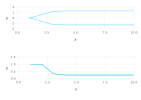

In [340]:
m = Model(solver=Gurobi.GurobiSolver(OutputFlag=1))
num_links = 2
n_major = 10
n_minor_per_major = 1
n = n_major * n_minor_per_major

@variable m theta[1:num_links, 1:n]
@variable m c[1:num_links, 1:n]
@variable m s[1:num_links, 1:n]

@variable m rho[1:num_links, 1:n_major, 1:5] Bin
@constraint m [i=1:num_links, j=1:n_major] sum(rho[i,j,:]) == 1

@constraint m [i=1:num_links, j=2:n] theta[i,j] <= theta[i,j-1] + 2pi/n
@constraint m [i=1:num_links, j=2:n] theta[i,j] >= theta[i,j-1] - 2pi/n

for i in 1:num_links
    for j_major in 1:n_major
        for j_minor in 1:n_minor_per_major
            j = (j_major - 1) * n_minor_per_major + j_minor
            trig_approximation!(m, theta[i,j], c[i,j], s[i,j], rho[i,j_major,:])
        end
    end
end

# for i in 2:n_major
#     for j in 1:length(rho[i-1])
#         @constraint m sum{rho[i][k], k=max(1, j-1):min(length(rho[i]), j+1)} >= rho[i-1][j]
#     end
# end

@constraint m theta[1, 1] == 0.05
@constraint m theta[2, 1] == -0.05
@constraint m [i=1:n] theta[2, i] - theta[1, i] >= -0.1

@objective m Min sum([(c[1, i] + c[2, i] - 0.5)^2 + (s[1, i] + s[2, i])^2 for i in 1:n])

status = solve(m)
@show getsolvetime(m)
@show status
@show getvalue(getobjective(m))
@show getvalue.(theta)

@show getvalue.(c)

vstack(plot(
layer(x=1:size(theta, 2), y=getvalue.(theta[1,:]), Geom.line),
layer(x=1:size(theta, 2), y=getvalue.(theta[2,:]), Geom.line)),
plot(
layer(x=1:size(theta, 2), y=getvalue.(c[1,:]), Geom.line),
layer(x=1:size(theta, 2), y=getvalue.(c[2,:]), Geom.line),
),
# plot(
# layer(x=1:size(theta, 2), y=getvalue.(s[1,:]), Geom.line),
# layer(x=1:size(theta, 2), y=getvalue.(s[2,:]), Geom.line),
# ),
)
# plot(layer(x=1:size(rho, 2), y=findfirst.(map(x -> x .> 0.5, getvalue.(rho))), Geom.point)))